The goal of this notebook is to implement the Bayesian LASSO method for a 1D problem.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import recipinvgauss
import scipy.sparse as sps
from scipy.sparse.linalg import cg

from fastprogress import progress_bar

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

from runningstatistics import StatsTracker
import jlinops
import sampi

# Make toy problem

In [191]:
ground_truth = jlinops.piecewise_constant_1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
noise_stdev = 0.05
noise_var = noise_stdev**2
blur_sigma = 4.0
#blur_op = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma, mode="constant")
blur_op = jlinops.IdentityOperator((n,n))
noisy_signal = blur_op.matvec(ground_truth) + noise_stdev*np.random.normal(size=n)
grid = np.arange(n)

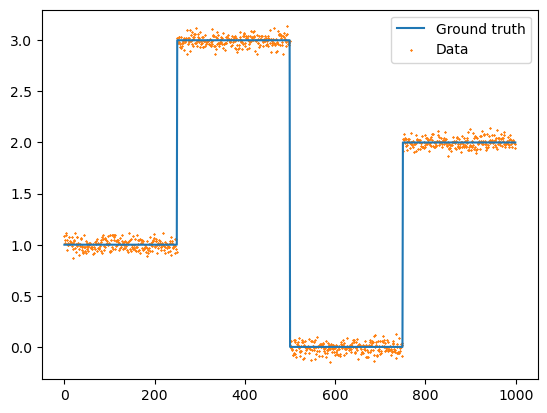

In [192]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

In [193]:
# Define forward operator and regularization matrix
F = blur_op
R, _ = jlinops.first_order_derivative_1d(n, boundary="none")
R = jlinops.MatrixLinearOperator(R)

# Set regularization lambda
reg_lambda = 3

# MAP estimate of the L1 problem

By L1 problem, I mean solving
$$
\operatorname{argmin}_x \left\{ \frac{1}{2 \sigma^2} \| x - y \|_2^2 + \lambda \| R x \|_1 \right\} = \operatorname{argmin}_x \left\{ \frac{1}{2} \| x - y \|_2^2 + (\lambda \sigma^2) \| R x \|_1 \right\}.
$$

In [194]:
# We can solve this problem using FISTA
f = sampi.GaussianDataLikelihood(F, noisy_signal, v=noise_var)
g = sampi.TV1DPenalty(n, boundary="none", reg_lam=reg_lambda)
obj = sampi.CompositeModelObjectiveFunction(f, g)
solver = sampi.MFISTASolver(obj)
mfista_solver_data = solver.solve(iterations=100, L=None)

[]

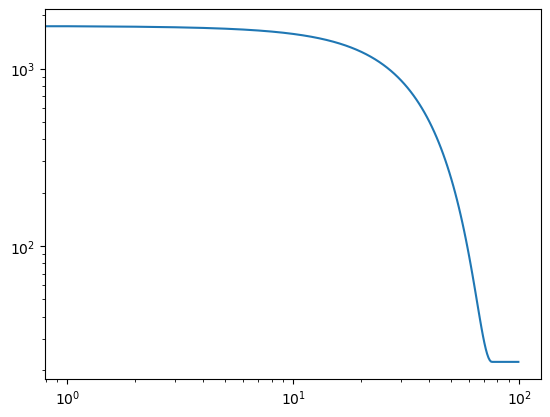

In [195]:
plt.loglog(mfista_solver_data["obj_vals"])
plt.plot()

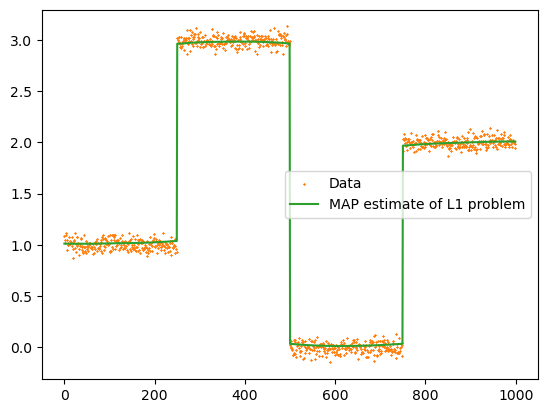

In [196]:
map_result = mfista_solver_data["result"]
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.plot(grid, map_result, label="MAP estimate of L1 problem", color="C2")
plt.legend()
plt.show()

# Sample the posterior of the Gaussian model

$$
-\log \pi(x)  = \left\{ \frac{1}{2 \sigma^2} \| x - y \|_2^2 + \frac{\lambda}{2} \| R x \|_2^2 \right\} + C
$$

In [197]:
# def gauss_posterior_summary(F, R, y, noise_var=1.0, reg_lambda=1e1):
#     """Computes posterior mean and stdev.
#     """
#     Q = sps.csc_matrix((1/noise_var)*(F.A.T @ F.A) + reg_lambda*(R.A.T @ R.A))
#     Q = jlinops.MatrixLinearOperator(Q)
#     Linv = jlinops.BandedCholeskyFactorInvOperator(Q)
#     mean = Linv.T @ (Linv @  ((1/noise_var)*F.T @ y) )

#     # Get diagonal entries of Qinv
#     Qinv = Linv.T @ Linv
#     var = jlinops.black_box_diagonal(Qinv)
#     stdev = np.sqrt(var)
#     return mean, stdev

In [198]:

# gauss_mu, gauss_sigmas = gauss_posterior_summary(F, R, noisy_signal, noise_var=noise_var, reg_lambda=1e4)

In [199]:
# #plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
# plt.plot(grid, gauss_mu, label="Mean vector", color="C2")
# plt.fill_between(grid, gauss_mu - 3*gauss_sigmas, gauss_mu + 3*gauss_sigmas, color="C4", alpha=0.5, label="3 sigma band")
# plt.legend()
# plt.show()

# Inverse Gaussian helper function

In [200]:
def sample_inv_gaussian(mu, lam):
    """Draws samples of the inverse Gaussian distribution with parameters \mu and \lambda, where the density is
    p(x) \propto x^{-3/2} \exp\{ - \lambda*(x-\mu)^2 / (2 \mu^2 x)  \}.
    """
    mu = np.atleast_1d(mu)
    lam = np.atleast_1d(lam)

    if not len(mu) == len(lam):
        return None
    else:
        n = len(mu)


        # Draw nu
        nu = np.random.normal(size=n)

        # Square it
        y = nu**2

        # Compute x
        x = mu + (((mu**2)*y)/(2*lam)) - (mu/(2*lam))*np.sqrt( 4*mu*lam*y + ((mu*y)**2)  )

        # Generate z
        z = np.random.uniform(size=n)

        # Logic for last step
        true_cond = mu/(mu+x)
        true_idx = np.where(z <= true_cond)
        false_idx = np.where(z > true_cond)
        true_arr = x[true_idx]
        false_arr = (mu[false_idx]**2)/x[false_idx]
        result = np.zeros(n)
        result[true_idx] = true_arr.copy()
        result[false_idx] = false_arr.copy()

        return result




In [201]:
sample_inv_gaussian( np.random.uniform(size=10), np.random.uniform(size=10) )

array([0.31411418, 0.17436802, 0.75648412, 0.02526811, 0.06060087,
       0.39842245, 0.44774488, 0.02416   , 0.01388728, 0.37425689])

# Bayesian LASSO

In [202]:
class BayesianLASSOGibbsSampler:
    """Implements the Bayesian LASSO hierarchical sampler for the L1 problem.
    """

    def __init__(self, F, R, y, noise_var=1.0, reg_lambda_params={}):

        self.F = F
        self.R = R
        self.y = y
        self.noise_var = noise_var
        self.noise_stdev = np.sqrt(noise_var)
        self.reg_lambda_params = reg_lambda_params
        self.delta = reg_lambda_params["delta"]
        self.r = reg_lambda_params["r"]
        
        self.m = F.shape[0]
        self.k = R.shape[0]
        self.n = R.shape[1]

        self.last_x_solve = None


    def sample(self, n_samples, x0=None, n_burn=0, theta_tol=1e-2, reg_etasq0=None, x_params={}):
        """Runs the Gibbs sampler.
        """

        # Initialize
        if x0 is None:
            x = np.zeros(self.F.shape[1])
        else:
            x = x0

        if reg_etasq0 is None:
            reg_etasq = 1.0
        else:
            reg_etasq = reg_etasq0

        # Create trackers
        x_tracker = StatsTracker(self.F.shape[1])
        theta_tracker = StatsTracker(self.R.shape[0])

        # For taking care of lambda udpates
        # lam_update_fn = lambda theta_ss_est: np.sqrt( 2*self.R.shape[0]/theta_ss_est )
        # theta_sum_tracker = StatsTracker((1,))
        # lam_hist = [lam]
        # theta_sums_all = []
        reg_eta_hist = [reg_etasq]
      


        # For tracking when gaussian draws are accepted
        x_draws_accepted = 0

        # Run the sampler
        for j in progress_bar(range(n_samples+n_burn)):

            # Update theta
            theta = self.sample_theta(x, reg_etasq, tol=theta_tol)

            # Update x
            x, accepted = self.sample_x(theta, x, **x_params)
            if j >= n_burn:
                if accepted:
                    x_draws_accepted += 1

            # Get new eta_sq
            #reg_etasq = self.sample_reg_etasq(theta)
            reg_eta_hist.append(reg_etasq)

            # Push to tracker
            if j >= n_burn:
                x_tracker.push(x)
                theta_tracker.push(theta)

        
        results = {
            "x_tracker": x_tracker,
            "theta_tracker": theta_tracker,
            "etasq_hist": np.asarray(reg_eta_hist),
            "lam_hist": 1.0/np.asarray(reg_eta_hist),
            "x_draws_acceptance_rate": x_draws_accepted/n_samples,
        }

        return results


    def sample_x(self, theta, x_old, cg_maxits=None, cg_tol=1e-3, ar_step=True):
        """Given local variances theta, draws a sample for x.
        """


        # Update using RJPO method
        if cg_maxits is None:
            cg_maxits = self.n
        
        # Sample eta
        Ls = [ (1.0/self.noise_stdev)*self.F.T, self.R.T @ jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta))) ]
        Qmu = (1.0/self.noise_var)*(self.F.T @ self.y)
        eta = self.sample_eta(Qmu, Ls)

        # Solve system approximately
        Q = (1.0/self.noise_var)*(self.F.T @ self.F) + (self.R.T @ ( jlinops.MatrixLinearOperator(sps.diags(1.0/theta)) @ self.R ) )
        if self.last_x_solve is None:
            warmstart = None
        else:
            warmstart = - self.last_x_solve
        x_approx, _ = cg(Q, eta, x0=warmstart, maxiter=cg_maxits, tol=cg_tol)
        
        if not ar_step:
            return x_approx, True

        # x_approx = x_approx_solve["x"]
        # tot_cg_its += x_approx_solve["iterations"]

        # Compute residual
        # print(eta)
        # print(Q @ x_approx)
        #print(x_approx)
        residual = eta - (Q @ x_approx)

        # Accept or reject
        log_uniform = np.log(np.random.uniform())
        log_accept = np.amin([0.0, -residual.T @ (x_old - x_approx)])

        if log_uniform < log_accept:
            x = x_approx
            accepted = True
        else:
            x = x_old
            accepted = False

        self.last_x_solve = x

        return x, accepted

    

    def sample_theta(self, x, etasq, tol=1e-4):
        """Given x, draws a sample for the thetas.
        """

        # Get Rx
        Rx = self.R @ x

        # Make output array
        sample = np.zeros(self.R.shape[0])


        # Need to check where Rx is close to zero, so we can sample from exponential there instead
        idx_too_small = np.where(np.abs(Rx) < tol)
        idx_fine = np.where(np.abs(Rx) >= tol)

        # Break into two parts
        Rx_too_small = Rx[idx_too_small]
        Rx_fine = Rx[idx_fine]

        # For the components near zero, sample from the exponential
        #theta_from_too_small = np.random.exponential(scale=1.0/lam, size=len(Rx_too_small))
        theta_from_too_small = np.random.gamma(0.5, scale=2.0*etasq, size=len(Rx_too_small))

        # For the components not near zero, sample from the inverse Gaussian
        mu = np.abs(Rx_fine)/np.sqrt(etasq)
        lam = 1.0/etasq
        #theta_from_fine = sample_inv_gaussian(mu, lam)
        theta_from_fine = np.random.wald(mu, scale=lam)
        # theta_from_fine = recipinvgauss.rvs(mu=np.abs(Rx_fine)/np.sqrt(etasq), scale=1.0/(lam**2))

        # Put all into one array
        sample[idx_too_small] = theta_from_too_small
        sample[idx_fine] = theta_from_fine

        #sample += 1e-10
        assert np.all(sample > 0), "some thetas are no positive!"
        

        return sample


    def sample_eta(self, Qmu, Ls):
        """Draws a sample from $\mathcal{N}(Q \mu, Q)$. Here $Q$ is assumed to be of the form $Q = \sum_{i=1}^p L_i^T L_i$,
        where the $L_i$ are collected in Ls."""
         
        # Draw sample with correct covariance
        sample = np.zeros(self.n)
        for L in Ls:
            sample += L.matvec( np.random.normal(size=L.shape[1]) )

        # Add mean
        sample += Qmu
        
        return sample
    

    def sample_reg_etasq(self, theta):
        """Samples from the conditional for the regularization parameter.
        """
        
        shape_param = self.k + self.r
        rate_param = self.delta + 0.5*theta.sum()

        recip_reg_etasq = np.random.gamma(shape_param, scale=1.0/rate_param)
        reg_etasq = 1.0/recip_reg_etasq

        return reg_etasq

In [203]:
reg_lambda_params = {
    "r": 1.0,
    "delta": 1e-4
    , 
}

In [204]:
lasso_sampler = BayesianLASSOGibbsSampler(F, R, noisy_signal, noise_var=noise_var, reg_lambda_params=reg_lambda_params)

In [205]:
sampling_result = lasso_sampler.sample(n_samples=200, n_burn=100, reg_etasq0=1e-3, x_params={"cg_maxits":1000, "cg_tol":1e-3, "ar_step":False})

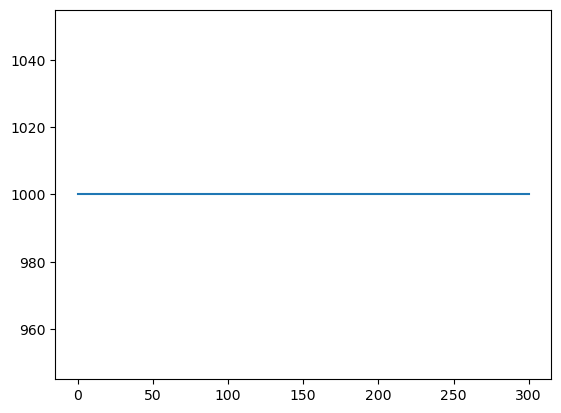

In [206]:
plt.plot(sampling_result["lam_hist"])
plt.show()

In [207]:
sampling_result["x_draws_acceptance_rate"]

1.0

In [208]:
sampling_result["lam_hist"][-1]

1000.0

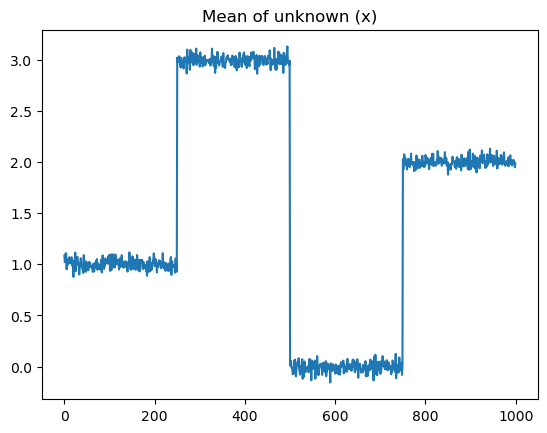

In [209]:
plt.plot(sampling_result["x_tracker"].mean())
plt.title("Mean of unknown (x)")
plt.show()

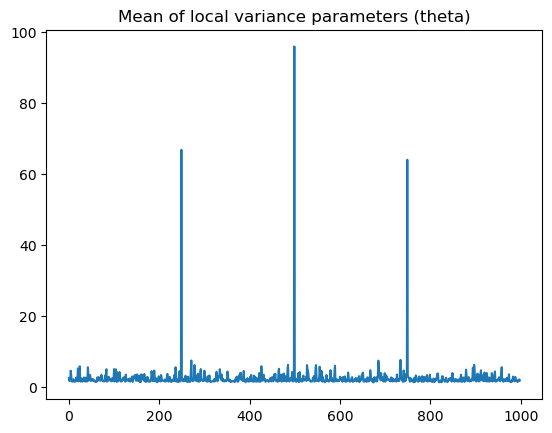

In [210]:
plt.plot(sampling_result["theta_tracker"].mean())
plt.title("Mean of local variance parameters (theta)")
plt.show()

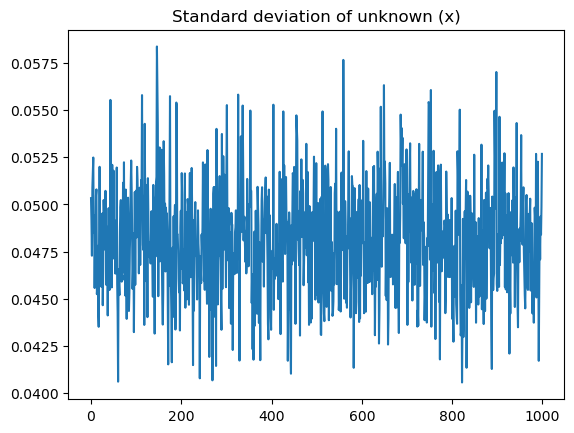

In [211]:
plt.plot(sampling_result["x_tracker"].stdev())
plt.title("Standard deviation of unknown (x)")
plt.show()

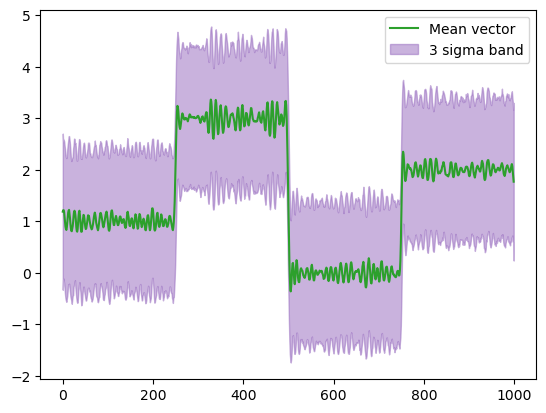

In [153]:
#plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
mu, stdev = sampling_result["x_tracker"].mean(), sampling_result["x_tracker"].stdev()
plt.plot(grid, mu, label="Mean vector", color="C2")
plt.fill_between(grid, mu - 3*stdev, mu + 3*stdev, color="C4", alpha=0.5, label="3 sigma band")
plt.legend()
plt.show()

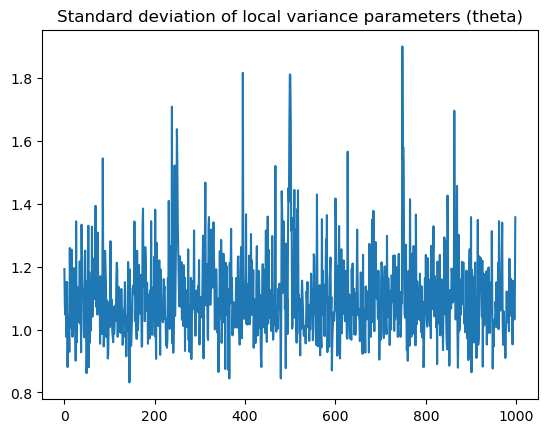

In [155]:
plt.plot(sampling_result["theta_tracker"].stdev())
plt.title("Standard deviation of local variance parameters (theta)")
plt.show()

# Comparison with other methods

In [156]:
# Do MAP again
f = sampi.GaussianDataLikelihood(F, noisy_signal, v=noise_var)
g = sampi.TV1DPenalty(n, boundary="none", reg_lam=sampling_result["lam_hist"][-1])
obj = sampi.CompositeModelObjectiveFunction(f, g)
solver = sampi.MFISTASolver(obj)
mfista_solver_data = solver.solve(iterations=5000, L=None)

In [157]:
f.L

419.93434263998745

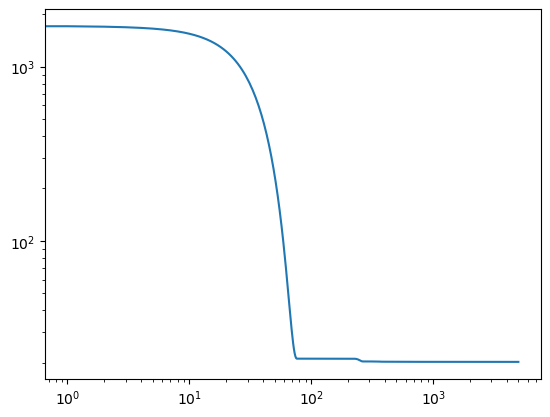

In [158]:
plt.loglog(mfista_solver_data["obj_vals"])
plt.show()

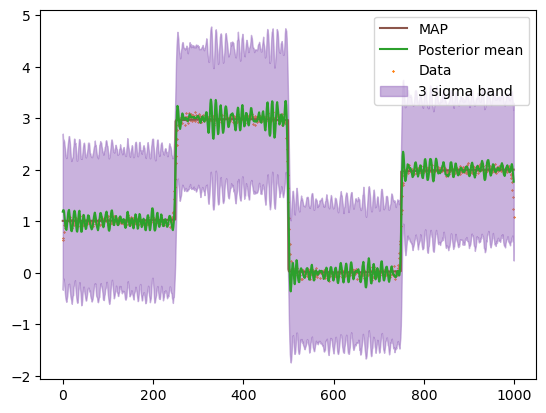

In [159]:
# Get MAP point for the lambda chosen during sampling
map_est = mfista_solver_data["result"]
#plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)

mu, stdev = sampling_result["x_tracker"].mean(), sampling_result["x_tracker"].stdev()

plt.plot(grid, map_est, label="MAP", color="C5")
plt.plot(grid, mu, label="Posterior mean", color="C2")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.fill_between(grid, mu - 3*stdev, mu + 3*stdev, color="C4", alpha=0.5, label="3 sigma band")
plt.legend()
plt.show()


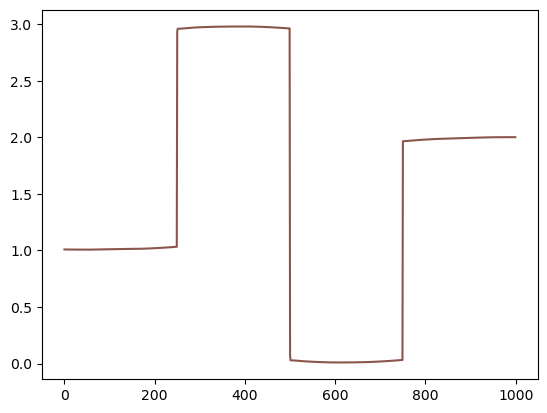

In [160]:
plt.plot(grid, map_est, label="MAP", color="C5")
plt.show()